In [76]:
import pandas as pd 
from wordfreq import zipf_frequency  # noqa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [77]:
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [78]:
# get pos tags for each word
import spacy 
from spacy_syllables import SpacySyllables  # noqa

model = "fr_core_news_lg"
if not spacy.util.is_package(model):
    import spacy.cli

    spacy.cli.download(model)  # type: ignore
nlp = spacy.load(model)
nlp.add_pipe("syllables", after="tok2vec")

In [389]:
content_function_word = {  # 1 content, 0 function, 2 others
    "ADJ": "content",
    "ADP": "function",
    "ADV": "content",
    "AUX": "function",
    "DET": "function",
    "NOUN": "content",
    "NUM": "function",
    "PRON": "function",
    "PROPN": "function",
    "VERB": "content",
    "INTJ": "function",
    "SCONJ": "function", 
    "CCONJ": "function", 
    "X": "nan", 
    "PUNCT": "function"
}


In [258]:
sentences = pd.read_csv("../text/full_with_translation.csv")
sentences.head()

,theme,type,structure,numer,tense,polarity,sentence,num_words,translation
0,weather,imperative,cleft,singular,present,negative,Don’t forget that it rains in spring\n,7,N'oubliez pas qu'il pleut au printemps.
1,weather,imperative,cleft,singular,present,negative,Please remember that winter is not always cold\n,8,S'il vous plaît rappelez-vous que l'hiver n'es...
2,weather,imperative,cleft,singular,present,negative,It is not my fault when the thunder strikes\n,9,Ce n'est pas de ma faute si le tonnerre frappe.
3,weather,imperative,cleft,singular,present,negative,You should know that summer does not last fore...,9,Tu devrais savoir que l'été ne dure pas éterne...
4,weather,imperative,cleft,singular,present,negative,Do not believe that snow is never beautiful\n,8,Ne croyez pas que la neige n'est jamais belle


# selection strategy 
- Sentences
- French
- Declarative
- P0: Simpler vocabulary
- P1: make sentence share words:
- P1: select N different sentences [4 words … 12 words]
- P2: within each group, two types syntactic difficulty
- doc = spacy.nlp(sentence)
- For word in doc:
- diff = np.abs(word.i - word.head.i)
- Word
- Do not block, mix trials with sentences.
- Word content only
- P2: multiple morpheme 

In [259]:
# get unique vocab 
def get_words_from_sentence(sentence):
    sentence = sentence.lower()
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct]
    num_words = len(words)
    return words, int(num_words)

sentences[['words', 'num_words_translation']] = sentences['translation'].apply(get_words_from_sentence).apply(pd.Series)
sentences.head()


,theme,type,structure,numer,tense,polarity,sentence,num_words,translation,words,num_words_translation
0,weather,imperative,cleft,singular,present,negative,Don’t forget that it rains in spring\n,7,N'oubliez pas qu'il pleut au printemps.,"[n', oubliez, pas, qu', il, pleut, au, printemps]",8
1,weather,imperative,cleft,singular,present,negative,Please remember that winter is not always cold\n,8,S'il vous plaît rappelez-vous que l'hiver n'es...,"[s', il, vous, plaît, rappelez, -vous, que, l'...",14
2,weather,imperative,cleft,singular,present,negative,It is not my fault when the thunder strikes\n,9,Ce n'est pas de ma faute si le tonnerre frappe.,"[ce, n', est, pas, de, ma, faute, si, le, tonn...",11
3,weather,imperative,cleft,singular,present,negative,You should know that summer does not last fore...,9,Tu devrais savoir que l'été ne dure pas éterne...,"[tu, devrais, savoir, que, l', été, ne, dure, ...",10
4,weather,imperative,cleft,singular,present,negative,Do not believe that snow is never beautiful\n,8,Ne croyez pas que la neige n'est jamais belle,"[ne, croyez, pas, que, la, neige, n', est, jam...",10


In [260]:
# exclude sents with et in them 

def include_et(words):
    return "et" in words

sentences["include_et"] = sentences.words.apply(include_et)
print(f"n sents with et {sentences.include_et.sum()}")
sentences = sentences[~sentences.include_et]

n sents with et 1488


Text(0.5, 1.0, 'Word frequency distribution')

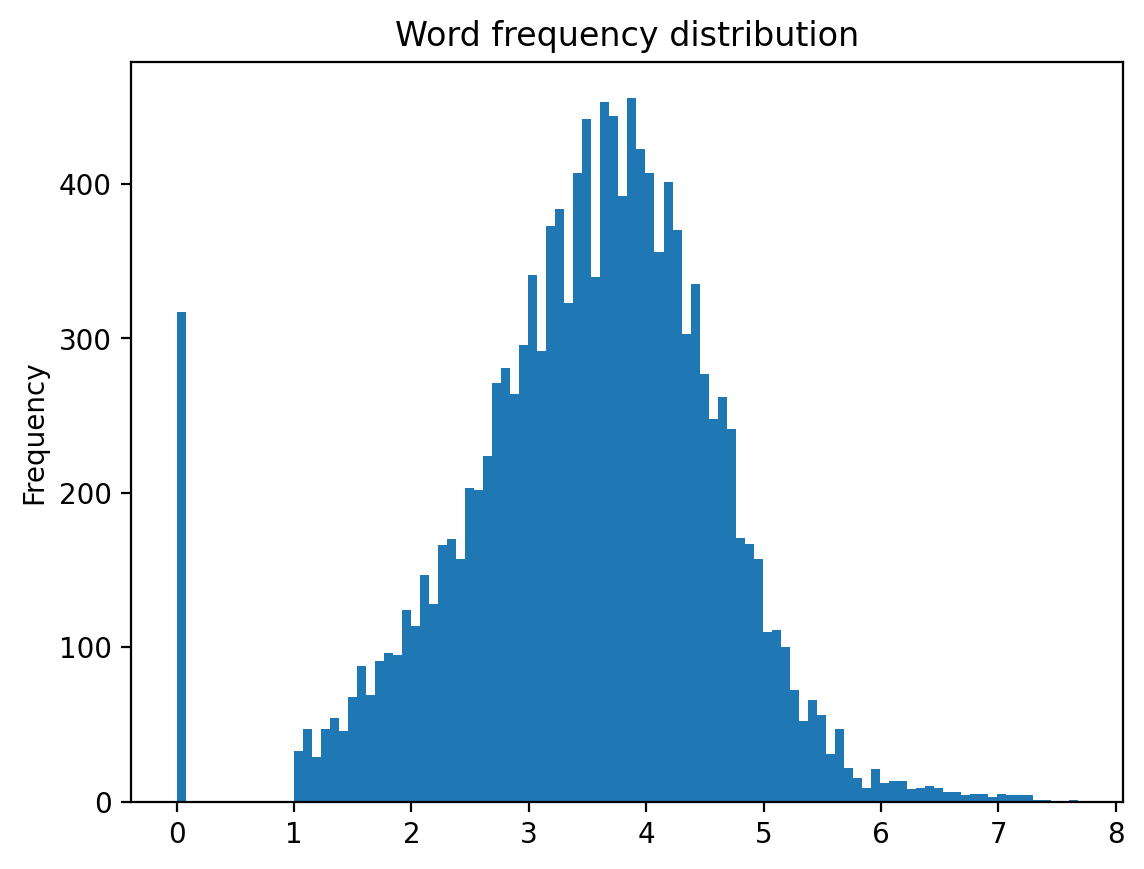

In [261]:
words = np.unique(np.concatenate((sentences.words.tolist())))

words_df = pd.DataFrame(words, columns=['word'])

words_df['word_freq'] = words_df['word'].apply(lambda x: zipf_frequency(x, 'fr'))

words_df.word_freq.plot.hist(bins=100)
plt.title('Word frequency distribution')

In [262]:
words_df.sort_values('word_freq', ascending=False).head(10)

,word,word_freq
3279,de,7.68
6787,la,7.43
6841,le,7.35
12820,à,7.26
6785,l,7.26
6786,l',7.26
6854,les,7.25
4717,est-,7.20
4716,est,7.20
4334,en,7.17


In [263]:
freq_cutoff = 4

words_df = words_df[words_df.word_freq > freq_cutoff]

len(words_df)

4487

In [264]:
words_df.sort_values('word_freq', ascending=True).head(10)

,word,word_freq
2162,circuits,4.01
3927,délicieux,4.01
3086,croyances,4.01
8616,placement,4.01
3987,dépenser,4.01
11512,start,4.01
2899,costumes,4.01
9929,remplie,4.01
5999,humide,4.01
1050,assises,4.01


Text(0.5, 1.0, 'Word frequency distribution post freq filter')

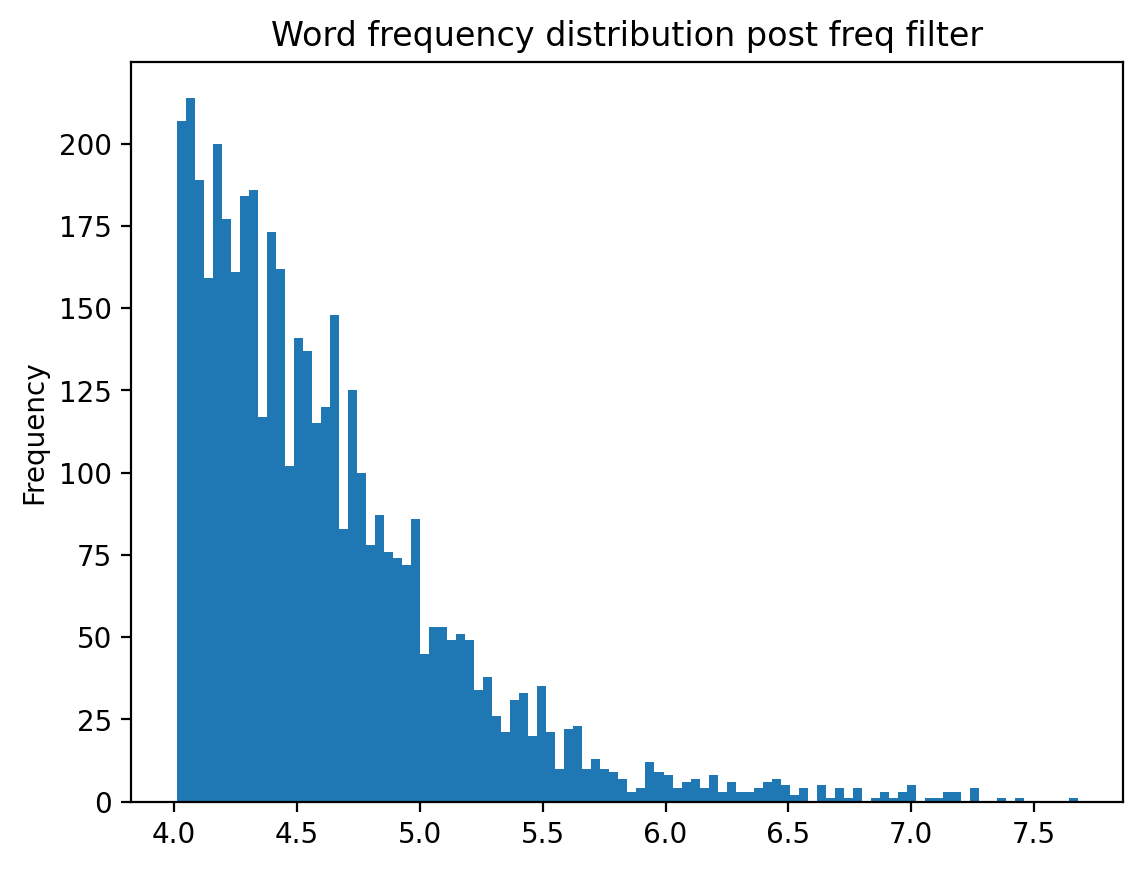

In [265]:
words_df.word_freq.plot.hist(bins=100)
plt.title('Word frequency distribution post freq filter')

In [339]:
# filter for sentences with frequence words 
def sent_in_vocab(words_in_sent):
    return all([word in words_df.word.values for word in words_in_sent])

sentences['in_vocab'] = sentences['words'].apply(sent_in_vocab)

sentences.in_vocab.sum()

5168

In [340]:
sentences_in_vocab = sentences[sentences.in_vocab]
sentences_in_vocab

,theme,type,structure,numer,tense,polarity,sentence,num_words,translation,words,num_words_translation,include_et,in_vocab
7,weather,imperative,cleft,singular,present,negative,It is not too late if the storm doesn't arrive\n,10,Il n'est pas trop tard si la tempête n'arrive pas,"[il, n', est, pas, trop, tard, si, la, tempête...",12,False,True
40,basic,declarative,simple,singular,future,negative,I will not go to the party tonight\n,8,Je n'irai pas à la fête ce soir.,"[je, n', irai, pas, à, la, fête, ce, soir]",9,False,True
51,basic,declarative,simple,singular,future,negative,My friend will not stay for coffee afterwards\n,8,Mon ami ne restera pas pour le café après.,"[mon, ami, ne, restera, pas, pour, le, café, a...",9,False,True
60,emotion,exclamatory,preposition,singular,present,affirmative,I feel joy in my heart!\n,6,Je sens la joie dans mon cœur!,"[je, sens, la, joie, dans, mon, cœur]",7,False,True
65,emotion,exclamatory,preposition,singular,present,affirmative,He dances with glee in the living room!\n,8,Il danse avec joie dans le salon!,"[il, danse, avec, joie, dans, le, salon]",7,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39941,science,exclamatory,preposition,plural,past,negative,The computers did not process data correctly!\n,7,Les ordinateurs n'ont pas traité les données c...,"[les, ordinateurs, n', ont, pas, traité, les, ...",9,False,True
39944,science,exclamatory,preposition,plural,past,negative,The researchers did not find enough evidence!\n,7,Les chercheurs n'ont pas trouvé assez de preuves!,"[les, chercheurs, n', ont, pas, trouvé, assez,...",9,False,True
39952,science,exclamatory,preposition,plural,past,negative,The students did not grasp the concept quickly!\n,8,Les élèves n'ont pas saisi le concept rapidement!,"[les, élèves, n', ont, pas, saisi, le, concept...",9,False,True
39953,science,exclamatory,preposition,plural,past,negative,The tests had not shown any improvement!\n,7,Les tests n'avaient montré aucune amélioration!,"[les, tests, n', avaient, montré, aucune, amél...",7,False,True


In [341]:
sentences_in_vocab.type.value_counts()

type
declarative      2181
exclamatory      1663
interrogative    1072
imperative        252
Name: count, dtype: int64

In [342]:
declarative = sentences_in_vocab[sentences_in_vocab.type == 'declarative']
declarative.structure.value_counts()

structure
cleft          561
simple         495
preposition    418
dependent      369
independent    338
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

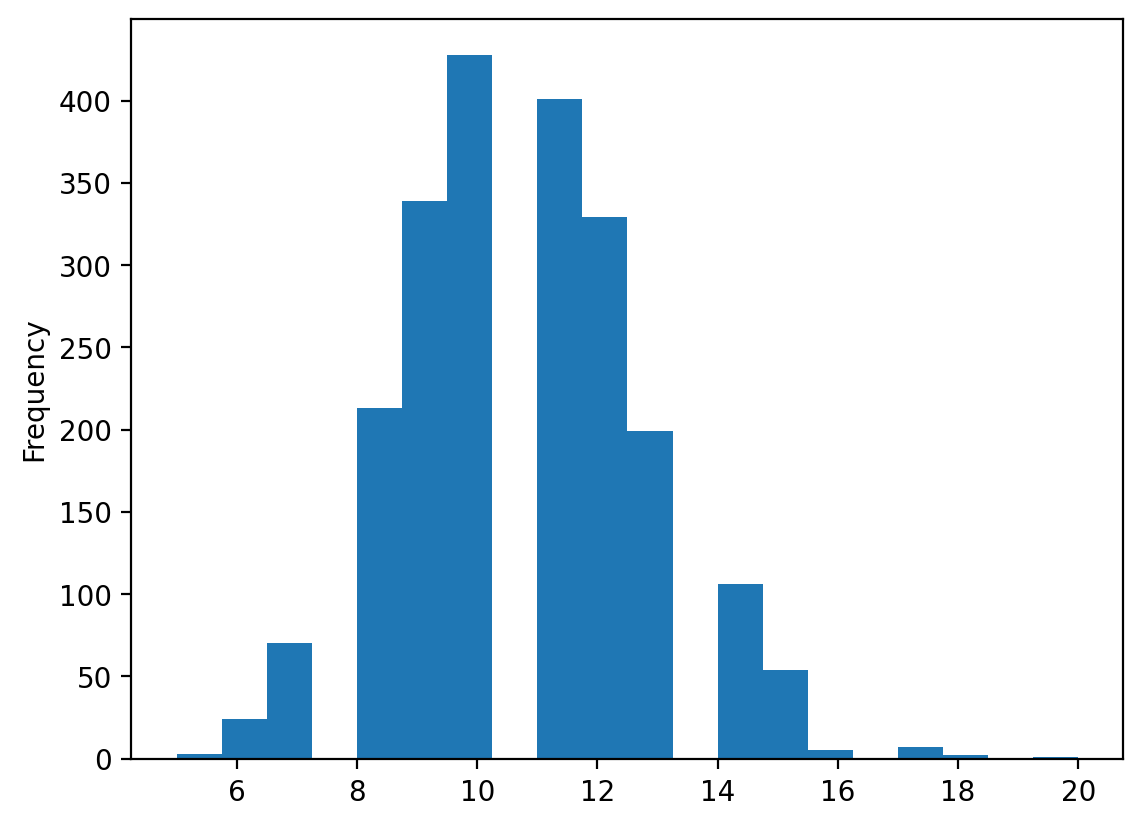

In [343]:
declarative.num_words_translation.plot.hist(bins=20)

<Axes: ylabel='Frequency'>

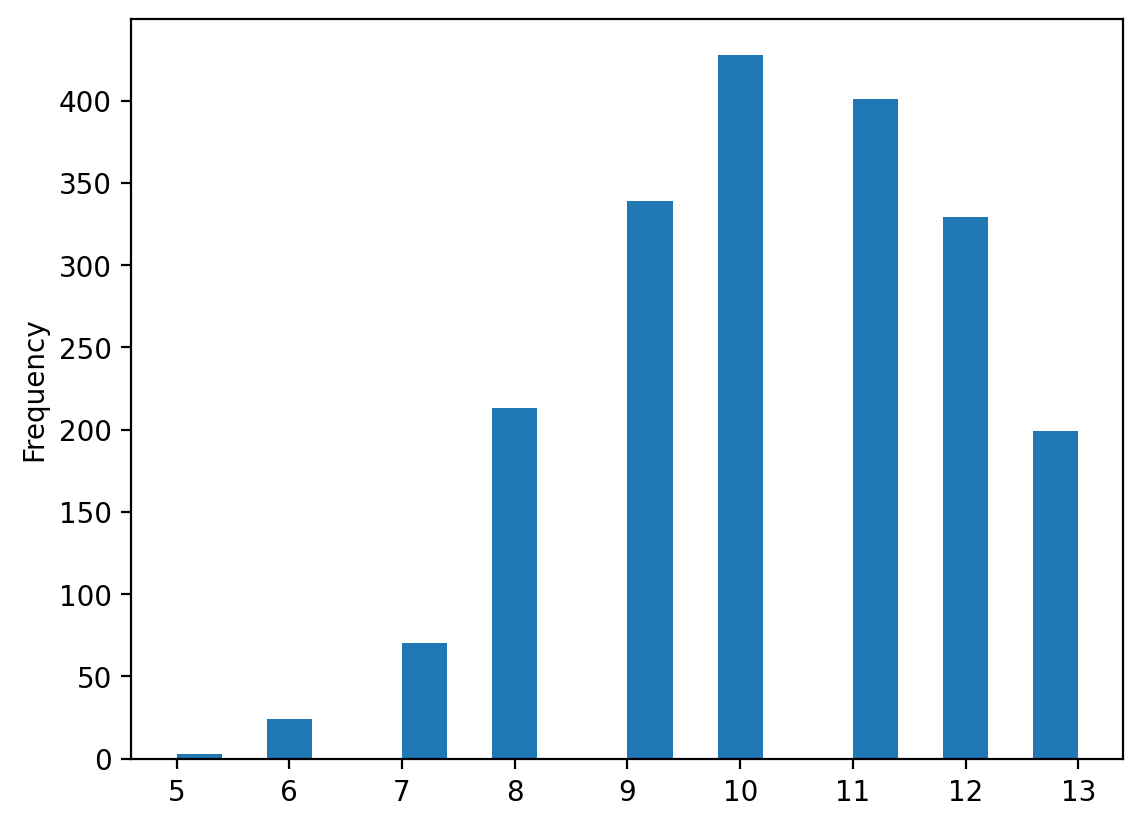

In [344]:
declarative = declarative.query('num_words_translation < 14')
declarative.num_words_translation.plot.hist(bins=20)


In [345]:
declarative


,theme,type,structure,numer,tense,polarity,sentence,num_words,translation,words,num_words_translation,include_et,in_vocab
40,basic,declarative,simple,singular,future,negative,I will not go to the party tonight\n,8,Je n'irai pas à la fête ce soir.,"[je, n', irai, pas, à, la, fête, ce, soir]",9,False,True
51,basic,declarative,simple,singular,future,negative,My friend will not stay for coffee afterwards\n,8,Mon ami ne restera pas pour le café après.,"[mon, ami, ne, restera, pas, pour, le, café, a...",9,False,True
361,humanity,declarative,simple,plural,present,negative,Many people do not trust the media\n,7,Beaucoup de gens ne font pas confiance aux méd...,"[beaucoup, de, gens, ne, font, pas, confiance,...",9,False,True
362,humanity,declarative,simple,plural,present,negative,Historians do not agree on every detail\n,7,Les historiens ne sont pas d'accord sur tous l...,"[les, historiens, ne, sont, pas, d', accord, s...",11,False,True
364,humanity,declarative,simple,plural,present,negative,Artists do not always follow trends\n,6,Les artistes ne suivent pas toujours les tenda...,"[les, artistes, ne, suivent, pas, toujours, le...",8,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39874,nature,declarative,dependent,singular,present,negative,A cloud that floats in the sky is not gray\n,10,Un nuage qui flotte dans le ciel n'est pas gris,"[un, nuage, qui, flotte, dans, le, ciel, n', e...",11,False,True
39879,nature,declarative,dependent,singular,present,negative,A leaf that falls in autumn does not remain gr...,10,Une feuille qui tombe en automne ne reste pas ...,"[une, feuille, qui, tombe, en, automne, ne, re...",10,False,True
39882,sport,declarative,simple,plural,past,negative,None of the players were tired after the game\n,9,Aucun des joueurs n'était fatigué après le match.,"[aucun, des, joueurs, n', était, fatigué, aprè...",9,False,True
39893,sport,declarative,simple,plural,past,negative,The teams had not set any records last season\n,9,Les équipes n'avaient pas établi de record la ...,"[les, équipes, n', avaient, pas, établi, de, r...",11,False,True


In [346]:
# check vocab of these sentences 
words = np.concatenate(declarative.words.values)

words, counts_w = np.unique(words, return_counts=True)

words_df = pd.DataFrame(words, columns=['word'])
words_df['counts'] = counts_w


In [347]:
# find vocab that have appeared at least three times 
# words_df = words_df[words_df['counts'] > 3]
# words_df

In [348]:
words_df.sort_values('counts', ascending=False).head(10)

,word,counts
1292,pas,1118
1169,n',686
990,le,681
995,les,649
512,de,617
981,la,562
1172,ne,488
980,l',418
2049,à,305
1,a,299


In [349]:
# content words
def get_pos_tags(text): 
    doc = nlp(text)
    tags = [token.pos_ for token in doc if (token.pos_ != "SPACE")]
    if len(tags) == 2:
        if tags[1] == "PUNCT":
            tags = [tags[0]]
        
    if (tags == ["DET", "DET"]) or (tags == ["ADP", "ADP"]):
        tags = [tags[0]]
    elif tags == ["SCONJ", "ADJ"]:
        tags = ["SCONJ"]
    
    if tags[0] == "PUNCT":
        tags = ["NOUN"]
    return tags[0]

words_df['pos_tags'] = words_df['word'].apply(get_pos_tags)
words_df.pos_tags.value_counts()

pos_tags
NOUN     945
VERB     622
ADJ      325
ADV       81
DET       34
PRON      30
ADP       29
AUX       27
PROPN     13
SCONJ      6
CCONJ      5
NUM        4
X          1
Name: count, dtype: int64

In [350]:
words_df['is_content'] = words_df['pos_tags'].apply(lambda x: content_function_word[x])
words_df.is_content.value_counts()

is_content
content     1973
function     148
nan            1
Name: count, dtype: int64

In [351]:
def sum_word_counts_sent(word_list: list):
    sum = 0
    n_contents = 0
    for w in word_list:
        if words_df.query("word==@w").empty:
            print(w)
            
        row = words_df.query("word==@w")
        if row.is_content.iloc[0] == "content":
            sum += row["counts"].iloc[0]
            n_contents += 1
    return sum  / n_contents

declarative["sum_word_counts_sent"] = declarative['words'].apply(sum_word_counts_sent)

In [352]:
declarative = declarative.sort_values('sum_word_counts_sent', ascending=False)
declarative.head(10)

,theme,type,structure,numer,tense,polarity,sentence,num_words,translation,words,num_words_translation,include_et,in_vocab,sum_word_counts_sent
29365,transport,declarative,dependent,singular,past,negative,I was not happy when the taxi did not arrive\n,10,Je n'étais pas content quand le taxi n'est pas...,"[je, n', étais, pas, content, quand, le, taxi,...",12,False,True,520.000000
8312,food,declarative,independent,singular,present,negative,He is not avoiding chocolate because he dislik...,9,Il n'évite pas le chocolat parce qu'il ne l'ai...,"[il, n', évite, pas, le, chocolat, parce, qu',...",13,False,True,499.571429
32424,basic,declarative,independent,singular,present,negative,You do not have to come if you don't want to\n,11,Tu n'es pas obligé de venir si tu ne veux pas.,"[tu, n', es, pas, obligé, de, venir, si, tu, n...",12,False,True,489.000000
10765,emotion,declarative,simple,singular,present,negative,I do not enjoy being alone\n,6,Je n'aime pas être seule.,"[je, n', aime, pas, être, seule]",6,False,True,473.250000
9871,food,declarative,cleft,singular,past,negative,It was not the fruit that I enjoyed most\n,9,Ce n'était pas le fruit que j'aimais le plus.,"[ce, n', était, pas, le, fruit, que, j', aimai...",11,False,True,469.500000
31940,relationship,declarative,cleft,plural,past,negative,They were not the friends I trusted\n,7,Ce n'étaient pas les amis en qui j'avais confi...,"[ce, n', étaient, pas, les, amis, en, qui, j',...",11,False,True,468.000000
12610,transport,declarative,cleft,singular,present,negative,It is not my friend who drives the van\n,9,Ce n'est pas mon ami qui conduit le van.,"[ce, n', est, pas, mon, ami, qui, conduit, le,...",10,False,True,465.500000
17664,relationship,declarative,cleft,singular,present,negative,That is not the friend I was talking about\n,9,Ce n'est pas l'ami dont je parlais.,"[ce, n', est, pas, l', ami, dont, je, parlais]",9,False,True,465.250000
8389,relationship,declarative,independent,singular,past,negative,You did not call your parents while you were a...,10,Tu n'as pas appelé tes parents pendant que tu ...,"[tu, n', as, pas, appelé, tes, parents, pendan...",12,False,True,462.750000
11310,basic,declarative,preposition,plural,present,negative,The students do not have their homework with t...,9,Les élèves n'ont pas leurs devoirs avec eux.,"[les, élèves, n', ont, pas, leurs, devoirs, av...",9,False,True,461.750000


In [395]:
def lemmas(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if (token.pos_ not in ["SPACE", "PUNCT"])]

declarative['lemmas'] = declarative.translation.apply(lemmas)
declarative.head()

,theme,type,structure,numer,tense,polarity,sentence,num_words,translation,words,num_words_translation,include_et,in_vocab,sum_word_counts_sent,lemmas
29365,transport,declarative,dependent,singular,past,negative,I was not happy when the taxi did not arrive\n,10,Je n'étais pas content quand le taxi n'est pas...,"[je, n', étais, pas, content, quand, le, taxi,...",12,False,True,520.000000,"[je, ne, être, pas, content, quand, le, taxi, ..."
8312,food,declarative,independent,singular,present,negative,He is not avoiding chocolate because he dislik...,9,Il n'évite pas le chocolat parce qu'il ne l'ai...,"[il, n', évite, pas, le, chocolat, parce, qu',...",13,False,True,499.571429,"[il, ne, éviter, pas, le, chocolat, parce, que..."
32424,basic,declarative,independent,singular,present,negative,You do not have to come if you don't want to\n,11,Tu n'es pas obligé de venir si tu ne veux pas.,"[tu, n', es, pas, obligé, de, venir, si, tu, n...",12,False,True,489.000000,"[tu, ne, être, pas, obliger, de, venir, si, tu..."
10765,emotion,declarative,simple,singular,present,negative,I do not enjoy being alone\n,6,Je n'aime pas être seule.,"[je, n', aime, pas, être, seule]",6,False,True,473.250000,"[je, ne, aimer, pas, être, seul]"
9871,food,declarative,cleft,singular,past,negative,It was not the fruit that I enjoyed most\n,9,Ce n'était pas le fruit que j'aimais le plus.,"[ce, n', était, pas, le, fruit, que, j', aimai...",11,False,True,469.500000,"[ce, ne, être, pas, le, fruit, que, je, aimer,..."


# find minimum set of sentences that have the most overlapping words 
- for each sent, check avg occurance of content words across the dataset 
- start with first 10 sents
    - create initial vocab 
    - check counts 
    - filter vocab that are least frequnt in current selection 
    - for remaining sentences, 
        - check overlap between sent words and least freq vocab
        - add sent with most overlap 
        - check counts 
            if all words counts >=3: 
                exist
            else: 
                - update vocab 
                - update remaining sents 


In [396]:
def is_content(word):
    doc = nlp((str(word)))
    pos = doc[0].pos_
    return content_function_word[pos] == "content"

In [398]:
from tqdm import tqdm, trange
n_samples = 1000
word_type = "lemmas"
trial = 0
min_infreq = 1

for s in trange(n_samples):
    # Sample selection and create a copy to avoid modifying original data
    selection = declarative.iloc[:20].sample(5).copy()
    
    # print("resampling")
    
    # Initialize remaining index after creating selection
    remaining_idx = declarative.index.difference(selection.index)
    remaining = declarative.loc[remaining_idx]

    # Compute vocabulary and counts for the current selection
    vocab, counts = np.unique(np.concatenate(selection[word_type].values), return_counts=True)
    is_content_mask = np.array([is_content(w) for w in vocab])
    vocab = vocab[is_content_mask]
    counts = counts[is_content_mask]

    while (counts < 3).sum() > 0:    
        # Identify infrequent vocab words
        infrequent_vocab = [vocab[i] for i in range(len(counts)) if counts[i] < 3]
        proportion = len(infrequent_vocab) / len(vocab)

        # Update min_infreq and save results if the current proportion is lower
        if (proportion < min_infreq) and (len(selection) > 200):
            min_infreq = proportion
            print(min_infreq, s)
            selection.to_csv(f"../text/selection_min_{trial}.csv")

        # If no infrequent vocab, break the loop and save the selection
        if len(infrequent_vocab) == 0:
            selection.to_csv(f"../text/selection_min_{trial}.csv")
            break

        # Convert infrequent_vocab to a set for faster lookup
        infrequent_vocab_set = set(infrequent_vocab)

        # Compute overlap for remaining sentences based on infrequent vocab
        def words_in_vocab(word_list): 
            return np.mean([word in infrequent_vocab_set for word in word_list])

        # Apply the overlap function to remaining sentences
        remaining["overlap"] = remaining[word_type].apply(words_in_vocab)

        # Sort remaining by overlap and select the top sentence to add to selection
        remaining = remaining.sort_values("overlap", ascending=False)
        selection = pd.concat([selection, remaining.head(1)])
        
        # Update remaining_idx by removing the selected row
        remaining_idx = remaining.index.difference(selection.index)
        remaining = remaining.loc[remaining_idx]

        # Recompute vocab and counts after adding the new sentence
        vocab, counts = np.unique(np.concatenate(selection[word_type].values), return_counts=True)

        # Stop if selection exceeds 200 sentences
        if len(selection) > 256:
            break


  0%|          | 0/1000 [00:00<?, ?it/s]

0.35537190082644626 0
0.35342465753424657 0
0.35294117647058826 0
0.352 0
0.35106382978723405 0
0.35051546391752575 0
0.3496143958868895 0
0.3494897959183674 0
0.3477157360406091 0
0.34430379746835443 0


  0%|          | 1/1000 [00:01<31:37,  1.90s/it]

0.34328358208955223 0
0.3383084577114428 0
0.3371824480369515 0


  0%|          | 2/1000 [00:03<31:01,  1.87s/it]

0.31378299120234604 2
0.31213872832369943 2


  9%|▉         | 90/1000 [02:55<29:37,  1.95s/it]

0.30861244019138756 89


 11%|█         | 109/1000 [03:33<29:50,  2.01s/it]

0.3068181818181818 109
0.3064516129032258 109


 17%|█▋        | 168/1000 [05:28<26:56,  1.94s/it]

0.3031026252983294 167


 22%|██▏       | 215/1000 [07:00<25:08,  1.92s/it]

0.3021978021978022 215


 29%|██▉       | 294/1000 [09:33<22:45,  1.93s/it]

0.3015463917525773 293
0.30077120822622105 293
0.29743589743589743 293


 35%|███▍      | 348/1000 [11:19<21:19,  1.96s/it]

0.2948328267477204 348
0.29253731343283584 348
0.2916666666666667 348


100%|██████████| 1000/1000 [32:31<00:00,  1.95s/it]


In [321]:
selection

,theme,type,structure,numer,tense,polarity,sentence,num_words,translation,words,num_words_translation,include_et,in_vocab,sum_word_counts_sent,29054
2443,housing,declarative,independent,singular,present,negative,The kitchen is not organized because I have no...,10.0,La cuisine n'est pas organisée parce que je n'...,"[la, cuisine, n', est, pas, organisée, parce, ...",14.0,False,True,579.571429,NaN
29365,transport,declarative,dependent,singular,past,negative,I was not happy when the taxi did not arrive\n,10.0,Je n'étais pas content quand le taxi n'est pas...,"[je, n', étais, pas, content, quand, le, taxi,...",12.0,False,True,574.714286,NaN
32430,basic,declarative,independent,singular,present,negative,You do not need to apologize if you were not w...,11.0,Vous n'avez pas besoin de vous excuser si vous...,"[vous, n', avez, pas, besoin, de, vous, excuse...",14.0,False,True,574.142857,NaN
17149,basic,declarative,independent,singular,past,negative,I did not understand the question because it w...,10.0,Je n'ai pas compris la question parce qu'elle ...,"[je, n', ai, pas, compris, la, question, parce...",14.0,False,True,572.142857,NaN
8312,food,declarative,independent,singular,present,negative,He is not avoiding chocolate because he dislik...,9.0,Il n'évite pas le chocolat parce qu'il ne l'ai...,"[il, n', évite, pas, le, chocolat, parce, qu',...",13.0,False,True,548.428571,NaN
32424,basic,declarative,independent,singular,present,negative,You do not have to come if you don't want to\n,11.0,Tu n'es pas obligé de venir si tu ne veux pas.,"[tu, n', es, pas, obligé, de, venir, si, tu, n...",12.0,False,True,537.142857,NaN
10765,emotion,declarative,simple,singular,present,negative,I do not enjoy being alone\n,6.0,Je n'aime pas être seule.,"[je, n', aime, pas, être, seule]",6.0,False,True,521.750000,NaN
9871,food,declarative,cleft,singular,past,negative,It was not the fruit that I enjoyed most\n,9.0,Ce n'était pas le fruit que j'aimais le plus.,"[ce, n', était, pas, le, fruit, que, j', aimai...",11.0,False,True,518.000000,NaN
31940,relationship,declarative,cleft,plural,past,negative,They were not the friends I trusted\n,7.0,Ce n'étaient pas les amis en qui j'avais confi...,"[ce, n', étaient, pas, les, amis, en, qui, j',...",11.0,False,True,517.500000,NaN
12610,transport,declarative,cleft,singular,present,negative,It is not my friend who drives the van\n,9.0,Ce n'est pas mon ami qui conduit le van.,"[ce, n', est, pas, mon, ami, qui, conduit, le,...",10.0,False,True,513.500000,NaN
